# Introduction

In this experiment, we use synthetized data. The goal is to retrieve parameters of dynamical system orbits, following an experiment proposed in https://jmlr.org/papers/volume18/16-337/16-337.pdf.

For this experiment we create datasets $\{(x_n, y_n) \mid n \in \mathbb{N} \}$ using the following recursive formula:
$$
\begin{cases}
x_{n+1} &= x_n + r \cdot (1 - y_n) \mod 1\\
y_{n+1} &= y_n + r \cdot (1 - x_{n+1}) \mod 1
\end{cases}
$$
Note that there are two parameters needed to create this dataset: the initial point $(x_0, y_0)$ and the so-called 'dynamical parameter' $r$.
Choosing different initial points $(x_0, y_0)$ for fixed $r$ will result in datasets that look fairly similar. However, changing the dynamical parameter $r$ will usually result in wildly different behaviours.

The goal of this notebook is to create a classification pipeline which leverages multiparameter persistence is some way to demonstrate the discriminative power that multiparameter persistence has to offer.
For this we create the dynamical parameters of interest are $r = 2.5, 3.5, 4.0, 4.1$ and $4.3$. For each $r$ we choose $50$ randomly chosen $(x_0, y_0) \in [0,1] \times [0,1]$ after which we created the truncated orbits $\{(x_n, y_n) \mid n \in [1000]\}$.

## Start up

In [ ]:
%pip install gudhi
%pip install eagerpy
%pip install tadasets
%pip install POT

import math
import numpy as np
import torch
import gudhi as gd
import matplotlib.pyplot as plt
import tadasets
from gudhi.representations.vector_methods import PersistenceImage
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull
from sklearn.neighbors import KDTree
from tqdm import tqdm
from itertools import combinations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.0/790.0 kB 6.6 MB/s eta 0:00:00


## Creation of the synthesized dataset

We are going to create and organise the different datasets in the following manner.
- Each row is a different datasets
- The first column will have the label. The rest of the columns will contain the coordinates. So the columns are ordered in the following manner:
$$
(\text{label}, x_0, x_1, \ldots, x_{N - 1}, y_0, \ldots, y_{N-1}),
$$
where $N$ denotes the amount of datapoints.



In [ ]:
# Seed for reproducibility
np.random.seed(1)

# Functions needed for creation of dataset
def fx(x, y, r):
  return (x + r * y * (1 - y)) % 1

def fy(x, y, r):
  return (y + r * x * (1 - x)) % 1

# Initial conditions
r_list = [2., 3.5, 4., 4.1, 4.3]
label_amount = len(r_list)
per_label_amount = 50
data_total_amount = 1000
no_noise_amount = 600

noise_amount = data_total_amount - no_noise_amount

coord_list = []
for label, r in enumerate(r_list):

  # Random starting points
  x0 = np.random.rand(per_label_amount)
  y0 = np.random.rand(per_label_amount)

  xlist = [x0]
  ylist = [y0]

  for i in range(no_noise_amount - 1):
    # Creation of new datapoint
    xn = fx(xlist[i], ylist[i], r)
    yn = fy(xn, ylist[i], r)

    # Keeping track of data\
    xlist.append(xn)
    ylist.append(yn)

  for _ in range(noise_amount):

    # Creation of random datapoint
    xn = np.random.rand(per_label_amount)
    yn = np.random.rand(per_label_amount)

    # Keeping track of data
    xlist.append(xn)
    ylist.append(yn)

  # A collection of all x and y coordinates
  xlist = np.stack(xlist).T
  ylist = np.stack(ylist).T

  # Concatenate the x, y coordinates and the label
  coords_pre = np.concatenate((xlist, ylist), 1)
  labels = np.full((per_label_amount,1), float(label))
  coords = np.concatenate((labels, coords_pre), 1)

  coord_list.append(coords)

coords = np.concatenate(coord_list)
coords = coords.astype(np.float32)

# Creation of the $\gamma$-filtration function and the creation of persistence diagrams

## Defining the functions

First, we create the function that traces a path in the bipersistence module dubbed $\gamma$ (gamma).
We also need its inverse to calculate the filtration value.

In [ ]:
def gamma(t, radius_subd, parameters):

    # In case t is torch tensor
    if isinstance(t, torch.Tensor):

        # Find out where t falls in the subdivision
        indices = (torch.searchsorted(radius_subd, t, right=True) - 1)

        # Extract alphas and differences of alphas
        alphas = parameters[1:]
        alphasdif = alphas[:-1] - alphas[1:]

        # Prepare the resulting tensor of outputs
        result = torch.zeros_like(t).to(radius_subd.device)

        # Divide times into two cases
        mask1 = (indices <= 0)
        mask2 = ~mask1

        # Calculate the sums of differences times alphas times the radii
        sums = torch.cumsum(alphasdif * radius_subd[1:], dim=0)

        # Compute result
        result[mask1] = parameters[1] * t[mask1] + parameters[0]
        result[mask2] = parameters[indices[mask2] + 1] * t[mask2] + sums[indices[mask2] - 1] + parameters[0]

        return result

    # Find out where t falls in the subdivision
    indices = np.searchsorted(radius_subd, t, side='right') - 1

    # Extract alphas and differences of alphas
    alphas = parameters[1:]
    alphasdif = alphas[:-1] - alphas[1:]

    # Perpare the resulting vector of outputs
    result = np.zeros_like(t)

    # Divide times into two cases
    mask1 = (indices <= 0)
    mask2 = ~mask1

    # Convert t into an array it is a scalar
    if np.isscalar(t):
        t = np.array(t)

    # Calculate the sums of differences times alphas times the radii
    sums = np.cumsum(alphasdif * radius_subd[1:])

    # Compute result
    result[mask1] = parameters[1] * t[mask1] + parameters[0]
    result[mask2] = parameters[indices[mask2] + 1]*t[mask2] +  sums[indices[mask2] - 1] + parameters[0]
    return result

def gamma_inverse(y, radius_subd, parameters):

    density_subd = gamma(radius_subd, radius_subd, parameters)

    # Treat the case when y is a tensor
    if isinstance(y, torch.Tensor):

        # Find out where t falls in the subdivision
        indices = torch.searchsorted(density_subd, y, right=True) - 1

        # Extract alphas and differences of alphas
        alphas = parameters[1:]
        alphasdif = alphas[:-1] - alphas[1:]

        # Prepare the resulting tensor of outputs
        result = torch.zeros_like(y).to(radius_subd.device)

        # Divide times into two cases
        mask1 = (indices <= 0)
        mask2 = ~mask1

        # Calculate the sums of differences times alphas times the radii
        sums = torch.cumsum(alphasdif * radius_subd[1:], dim=0)

        # Compute result
        result[mask1] = 1 / parameters[1] * y[mask1] - parameters[0] / parameters[1]
        result[mask2] = 1 / parameters[indices[mask2] + 1] * y[mask2] - (sums[indices[mask2] - 1] + parameters[0]) / parameters[indices[mask2] + 1]

        return result
    # Find out where t falls in the subdivision
    indices = np.searchsorted(density_subd, y, side='right') - 1

    # Extract alphas and differences of alphas
    alphas = parameters[1:]
    alphasdif = alphas[:-1] - alphas[1:]

    # Perpare the resulting vector of outputs
    result = np.zeros_like(y)

    # Divide times into two cases
    mask1 = (indices <= 0)
    mask2 = ~mask1

    # Convert t into an array it is a scalar
    if np.isscalar(y):
        y = np.array(y)

    # Calculate the sums of differences times alphas times the radii
    sums = np.cumsum(alphasdif * radius_subd[1:])

    # Compute result
    result[mask1] = 1/parameters[1] * y[mask1]  - parameters[0]/parameters[1]
    result[mask2] = 1/parameters[indices[mask2] + 1] * y[mask2] - (sums[indices[mask2] - 1] + parameters[0])/parameters[indices[mask2] + 1]
    return result

From here we need to define some helper functions to be able to calculate the filtration values of the persistence diagram.

In [ ]:
# Code to create pd
def DTM(X,query_pts,m):
    '''
    Compute the values of the DTM (with exponent p=2) of the empirical measure of a point cloud X.
    For Pytorch GPU acceleration, make sure X and query_pts are stored on the GPU

    Input:
    X: a nxd torch tensor or numpy array representing n points in R^d
    query_pts:  a kxd torch tensor or numpy array of query points
    m: parameter of the DTM in [0,1)

    Output:
    DTM_result: a kx1 torch tensor or numpy array contaning the DTM of the query points

    Example:
    X = torch.tensor([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
    Q = torch.tensor([[0,0],[5,5]])
    DTM_values = DTM(X, Q, 0.3)
    '''

    if isinstance(X, torch.Tensor):
        if type(X) is not type(query_pts):
            raise "The query_pts and should be of the same type as the reference point set X."

        # Computation of number of neighbors
        N_tot = X.size(dim=0)
        k = math.floor(m*N_tot) + 1

        # Computation of pairwise distance of all points
        distances = torch.cdist(X, query_pts)

        # Obtains k indices of the small distances
        _, indices = distances.topk(k, dim=1, largest=False)
        NN_Dist = torch.gather(distances, 1, indices)

        # Calculation of DTM values
        DTM_result = torch.sqrt(torch.sum(NN_Dist**2, dim=1) / k)
        return DTM_result
    else:
        if type(X) is not type(query_pts):
            "The query_pts and should be of the same type as the reference point set X."

        N_tot = X.shape[0]
        k = math.floor(m*N_tot)+1   # number of neighbors

        kdt = KDTree(X, leaf_size=30, metric='euclidean')
        NN_Dist, NN = kdt.query(query_pts, k, return_distance=True)

        DTM_result = np.sqrt(np.sum(NN_Dist*NN_Dist,axis=1) / k)

        return DTM_result

def s(simplex, DTM_values):
  return torch.max(DTM_values[simplex])

def orig_filt(simplex, pts):
    if len(simplex) == 1:
        return torch.tensor(0.0)
    else:
        simplex_coords = pts[simplex]
        # try:
        #     # Points with the largest distance are in the convex hull
        #     hull = ConvexHull(simplex_coords)

        #     # Extract the points forming the hull
        #     hullpoints = simplex_coords[hull.vertices,:]

        #     # Naive way of finding the best pair in O(H^2) time if H is number of points on hull
        #     hdist = cdist(hullpoints, hullpoints, metric='euclidean')

        #     # Get the farthest apart points
        #     bestpair = np.unravel_index(hdist.argmax(), hdist.shape)

        #     # Calculate the distance between the furthest pair
        #     distance = np.linalg.norm(hullpoints[bestpair[0]] - hullpoints[bestpair[1]])

        #     return torch.tensor(distance)
        # except:

        if isinstance(simplex_coords, torch.Tensor):
          # Calculate all pairwise distances
          alldist = torch.cdist(simplex_coords, simplex_coords)

          # Get the maximum distance and its indices
          max_distance = torch.max(alldist)
          indices = torch.where(alldist == max_distance)

          # Get the farthest apart points
          point1 = simplex_coords[indices[0][0]]
          point2 = simplex_coords[indices[1][0]]

          # Calculate the distance between the furthest pair
          distance = torch.dist(point1, point2)

          return distance

        # Naive way of finding the best pair in O(H^2) time if H is number of points on hull
        alldist = cdist(simplex_coords, simplex_coords, metric='euclidean')

        # Get the farthest apart points
        bestpair = np.unravel_index(alldist.argmax(), alldist.shape)

        # Calculate the distance between the furthest pair
        distance = np.linalg.norm(simplex_coords[bestpair[0]] - simplex_coords[bestpair[1]])
        return torch.tensor(distance)

def filtration_function(parameters, time_subd, simplex, DTM_values, pts):
    if len(simplex) == 0:
        return torch.tensor(float('inf'))

    dens = s(simplex, DTM_values)
    orig_filt_value = orig_filt(simplex, pts)
    gamma_inv = gamma_inverse(dens, time_subd, parameters)
    gamma_value = gamma(orig_filt_value, time_subd, parameters)


    if orig_filt_value >= gamma_inv:
        rhs = gamma_value - parameters[0]

        # Convert everything to 1 dimensional tensor
        rhs = rhs.unsqueeze(0)
        lhs = orig_filt_value.unsqueeze(0)

        # Calculate filtration value
        vec = torch.cat((lhs, rhs))
        filtration = torch.linalg.norm(vec, -float('inf'))
        return filtration
    else:
        lhs = gamma_inv.unsqueeze(0)
        rhs = (dens - parameters[0]).unsqueeze(0)

        vec = torch.cat((lhs, rhs))
        filtration = torch.linalg.norm(vec, -float('inf'))
        return filtration

Finally, we create the function that creates the persistence diagram. The assignment of the filtration values (more precisely, the creation of the simplex tree), happens in the code for `gamma_pd` instead of having a seperate `gamma_st` function. If we would make a seperate `gamma_st` function, we would have to repeat the calculation of the filtration value to make it differentiable for torch, hence we do everything at once.

In [ ]:
def gamma_pd(parameters, time_subd, pts, m=0.5, dimension_max=2):
  """
  Creation of persistence diagram by drawing a path of line-segments in the
  bipersistence module M_{(t,y)} = A(f^{-1}[-\infty, t))_y where f is the DTM
  function.

  Args:
    - parameters  : an array/tensor of shape (n, )
    - time_subd   : an array/tensor of shape (n-1,)
    - pts         : an array/tensor of shape (N, 2)
    - m           : float in interval [0,1)
    - dimension_max
                  : integer >= 1

  Example:
    parameters = torch.tensor([0.1, 0.5, 0.5, 3., 4.])
    time_subd  = torch.tensor([0., 0.1, 0.2, 0.3])
    pts        = torch.rand(200,2, dtype=torch.float32)
  """

  # Build the alpha complex
  alpha_complex = gd.AlphaComplex(points=pts)
  alpha_st = alpha_complex.create_simplex_tree()

  # Split up the case whether point set is a torch tensor or numpy array
  if isinstance(pts, torch.Tensor):

    # Calculation of DTM values
    N_tot = pts.size(dim=0)
    Y = torch.tensor([alpha_complex.get_point(i) for i in range(N_tot)], dtype=pts.dtype).to(pts.device)
    DTM_values = DTM(pts,Y,m)

    # Collection of vertices and edges
    vertices = []
    edges = [] # NOTE: THERE MIGHT BE A MORE EFFICIENT WAY USING TORCH.ZEROS
    for simplex in alpha_st.get_skeleton(2):

      # Add vertices to the vertices list
      if len(simplex[0])==1:
        i = simplex[0][0]
        vertices.append([i])

      # Add edges to the edges list
      if len(simplex[0])==2:
        i = simplex[0][0]
        j = simplex[0][1]
        edges.append([i,j])

    # Transform vertices and edges list into a tensor
    vertices = torch.tensor(vertices).to(pts.device)
    edges = torch.tensor(edges).to(pts.device)

    # Obtain the density values
    dens_edges = torch.max(DTM_values[edges], 1).values
    dens_vert = DTM_values

    # Obtain the original filtration values (radius/time)
    pts1 = pts[edges[:, 0]]
    pts2 = pts[edges[:, 1]]
    orig_edges = torch.norm(pts1 - pts2, dim=1).to(pts.device)
    orig_vert = torch.zeros(N_tot).to(pts.device)

    # Obtain the gamma (inverse) values for all simplices
    gamma_vert = gamma(orig_vert, time_subd, parameters)
    gamma_edges = gamma(orig_edges, time_subd, parameters)
    gamma_inv_vert = gamma_inverse(dens_vert, time_subd, parameters)
    gamma_inv_edges = gamma_inverse(dens_edges, time_subd, parameters)

    # Seperate cases
    mask_vert = orig_vert >= gamma_inv_vert
    mask_edges = orig_edges >= gamma_inv_edges

    # Calculate filtration values
    result_vert = torch.zeros(N_tot).to(pts.device)
    result_edges = torch.zeros(edges.shape[0]).to(pts.device)

    # Case 1: filtration val >= inverse
    rhs_vert = (gamma_vert[mask_vert] - parameters[0]).unsqueeze(0)
    rhs_edges = (gamma_edges[mask_edges] - parameters[0]).unsqueeze(0)
    lhs_vert = orig_vert[mask_vert].unsqueeze(0)
    lhs_edges = orig_edges[mask_edges].unsqueeze(0)

    vec_vert = torch.cat((lhs_vert, rhs_vert), 0).T
    vec_edges = torch.cat((lhs_edges, rhs_edges), 0).T

    result_vert[mask_vert] = torch.norm(vec_vert, dim=1, p=-float('inf'))
    result_edges[mask_edges] = torch.norm(vec_edges, dim=1, p=-float('inf'))

    # Case 2: filtration val < inverse
    rhs_vert = (dens_vert[~mask_vert] - parameters[0]).unsqueeze(0)
    rhs_edges = (dens_edges[~mask_edges] - parameters[0]).unsqueeze(0)
    lhs_vert = gamma_inv_vert[~mask_vert].unsqueeze(0)
    lhs_edges = gamma_inv_edges[~mask_edges].unsqueeze(0)

    vec_vert = torch.cat((lhs_vert, rhs_vert), 0).T
    vec_edges = torch.cat((lhs_edges, rhs_edges), 0).T

    result_vert[~mask_vert] = torch.norm(vec_vert, dim=1, p=-float('inf'))
    result_edges[~mask_edges] = torch.norm(vec_edges, dim=1, p=-float('inf'))

    # Construct simplex tree
    st = gd.SimplexTree()

    # Prepare simplices and results to be inserted
    edges_cpu = edges.transpose(0, 1)
    vertices_cpu = vertices.transpose(0,1)
    if vertices.is_cuda:
      vertices_cpu = vertices_cpu.to("cpu")
    else:
      vertices_cpu = vertices_cpu
    if edges.is_cuda:
      edges_cpu = edges_cpu.to("cpu")
    else:
      edges_cpu = edges_cpu
    if result_vert.is_cuda:
      result_vert_cpu = result_vert.to("cpu")
    else:
      result_vert_cpu = result_vert
    if result_edges.is_cuda:
      result_edges_cpu = result_edges.to("cpu")
    else:
      result_edges_cpu = result_edges

    # Inserting filtration values
    st.insert_batch(vertices_cpu.detach().numpy(), result_vert_cpu.detach().numpy())
    st.insert_batch(edges_cpu.detach().numpy(), result_edges_cpu.detach().numpy())

    # Expanding simplicial complex to get higher dimensional complex
    st.expansion(dimension_max)

    # # Calculating persistence: Apparently by doing this we miss the persistence pairs that also immediately die which apparently helps in the machine learning pipeline
    st.compute_persistence(2)
    p = st.persistence_pairs()

    # Calculating persistence
    # alpha_st.compute_persistence(2)
    # p = alpha_st.persistence_pairs()

    diag0 = []
    diag1 = []
    for simplex1, simplex2 in p:

      # Skipping essential features
      if len(simplex2) == 0:
       continue

      # Sort simplex
      simplex1, _ = torch.sort(torch.tensor(simplex1))
      simplex2, _ = torch.sort(torch.tensor(simplex2))
      simplex1 = simplex1.to(pts.device)
      simplex2 = simplex2.to(pts.device)

      # Calculation of birth value
      if len(simplex1) == 1:
        birth = result_vert[simplex1]
      elif len(simplex1) == 2:
        mask = torch.all(torch.eq(edges, simplex1),  dim=1)
        birth = result_edges[mask]
      else:
        birth = filtration_function(parameters, time_subd, simplex1, DTM_values, pts).unsqueeze(0)


      # Calculation of death value
      if len(simplex2) == 2:
        mask = torch.all(torch.eq(edges, simplex2),  dim=1)
        death = result_edges[mask]
      else:
        death = filtration_function(parameters, time_subd, simplex2, DTM_values, pts).unsqueeze(0)

      # Append the pair of values to the results
      pd_point = torch.cat((birth, death))
      if len(simplex1) == 1:
        diag0.append(pd_point)
      elif len(simplex1) == 2:
        diag1.append(pd_point)
    if len(diag0) != 0:
      diag0 = torch.stack(diag0, dim=0)
    else:
      diag0 = torch.tensor([[0,0]], dtype=torch.float32).to(parameters.device)
      diag0.requires_grad = True
    if len(diag1) != 0:
      diag1 = torch.stack(diag1, dim=0)
    else:
      diag1 = torch.tensor([[0,0]], dtype=torch.float32).to(parameters.device)
      diag1.requires_grad = True


    return [diag0, diag1]

## Creation of the persistence diagrams

Given the above functions, we would like to create a function that inputs the point sets (and some parameters) that immediately gives us all the persistence diagrams.

In [ ]:
def create_pd_collec(coords, parameters, time_subd, m=0.1):

  # Obtain information about the coords so that we can extract point set per r
  data_total_amount = int((coords.shape[1] - 1)/2)

  # Create point set for each coordinate
  diag0_list = []
  diag1_list = []
  for coord in coords:

    # Extract x and y coordinates and combine into point set
    x = coord[1 : data_total_amount+1]
    y = coord[data_total_amount + 1: ]
    pts = torch.stack((x, y), dim=-1)

    # Creation of diagram
    diag0, diag1 = gamma_pd(parameters, time_subd, pts, m)
    diag0_list.append(diag0)
    diag1_list.append(diag1)

  return diag0_list, diag1_list

## Defining the loss

We now want to create a loss function that makes the distance larger smaller diagrams of the same label and normalize that somehow.
The values of the persistent diagram depend on our choice of our parameters, represented by the vector $\alpha$.

So our loss is given by
$$
L(\alpha) = \sum_{l = 1}^{N} \frac{\sum_{i,j: y_i = y_j = l} SW_p(D^0_i(\alpha), D^0_j(\alpha))}{\sum_{i,j: y_i = l} SW_p(D^0_i(\alpha), D^0_j(\alpha))} + \sum_{l = 1}^{N} \frac{\sum_{i,j: y_i = y_j = l} SW_p(D^1_i(\alpha), D^1_j(\alpha))}{\sum_{i,j: y_i = l} SW_p(D^1_i(\alpha), D^1_j(\alpha))}.
$$
Here $l$ represents the label (which in our case can be different values of $r$), the indices $i,j$ in the sums in the fraction represent the $i$-th and $j$-th dataset respectively, $D^k_i(\alpha)$ is the persistence diagram of the $i$-th dataset with the $\gamma_\alpha$ filtration of dimension $k$ and $y_i$ is the label of the $i$-th dataset.

In [ ]:
def general_sliced_wasserstein_distance(dgms, thetas):
    """
    Args:
        dgms: list of persistent diagrams
        ccards: cumulative sum of diagram cardinalities (ccards = np.cumsum([0]+[dgm.shape[0] for dgm in dgms]))
        thetas: angles parametrizing the lines

    Returns:
        - Sliced wasserstein distance
    """

    # Convert ccards and thetas to tensor in case it is not a tensor
    ccards = torch.tensor(np.cumsum([0] + [dgm.shape[0] for dgm in dgms])).to(thetas.device)

    dgm_cat = torch.cat(dgms,dim=0).to(torch.float32).to(thetas.device)
    projected_dgms = torch.matmul(dgm_cat, .5*torch.ones(size=(2,2), dtype=torch.float32).to(thetas.device))
    dgms_temp = [torch.reshape(
        torch.cat([dgm, projected_dgms[:ccards[idg]], projected_dgms[ccards[idg+1]:]], dim=0), \
            [-1,2,1,1]) for idg, dgm in enumerate(dgms)]
    dgms_big = torch.cat(dgms_temp, dim=2)
    cosines, sines = torch.cos(thetas), torch.sin(thetas)
    vecs = torch.cat([torch.reshape(cosines,[1,1,1,-1]), torch.reshape(sines,[1,1,1,-1])], dim=1)
    theta_projs, _ = torch.sort(torch.sum(torch.mul(dgms_big, vecs), dim=1), dim=0)

    t1 = torch.reshape(theta_projs, [ccards[-1], -1, 1, thetas.shape[0]])
    t2 = torch.reshape(theta_projs, [ccards[-1], 1, -1, thetas.shape[0]])

    dists = torch.mean(torch.sum(torch.abs(t1 - t2), dim = 0), dim = 2)
    return dists

def sliced_wasserstein_distance(dgms, thetas):
    # ccards = torch.tensor(np.cumsum([0] + [dgm.shape[0] for dgm in dgms]))
    dists = general_sliced_wasserstein_distance(dgms, thetas)
    dist = dists[0,1]
    return dist

In [ ]:
def loss_class_old(diag0_list, diag1_list, parameters, time_subd, label_amount, per_label_amount, m=0.1):

  # Needed for sliced wasserstein
  thetas = torch.tensor([[1/2, 1/3]]).to(parameters.device)
  pd0combi = []
  pd1combi = []
  for l in range(label_amount):
    pd0combi.append(combinations(diag0_list[per_label_amount * l : per_label_amount * (l + 1)], 2))
    pd1combi.append(combinations(diag1_list[per_label_amount * l : per_label_amount * (l + 1)], 2))

  pd0combi_all = combinations(diag0_list, 2)
  pd1combi_all = combinations(diag1_list, 2)

  loss = 0
  for l in range(label_amount):
    loss0_num = 0
    loss0_denum = 0
    loss1_num = 0
    loss1_denum = 0
    for diagi, diagj in pd0combi[l]:
      dists = [sliced_wasserstein_distance([diagi, diagj], theta) for theta in thetas]
      loss0_num += dists[0]

    for diagi, diagj in pd1combi[l]:
      dists = [sliced_wasserstein_distance([diagi, diagj], theta) for theta in thetas]
      loss1_num += dists[0]

    for diagi in diag0_list[per_label_amount * l : per_label_amount * (l + 1)]:
      for diagj in diag0_list:
        if not torch.equal(diagi, diagj):
          dists = [sliced_wasserstein_distance([diagi, diagj], theta) for theta in thetas]
          loss0_denum += dists[0]

    for diagi in diag1_list[per_label_amount * l : per_label_amount * (l + 1)]:
      for diagj in diag1_list:
        if not torch.equal(diagi, diagj):
          dists = [sliced_wasserstein_distance([diagi, diagj], theta) for theta in thetas]
          loss1_denum += dists[0]

    loss += loss0_num/loss0_denum + loss1_num/loss1_denum

  return loss

In [ ]:
import random

def split(lst, n):
  k, m = divmod(len(lst), n)
  for i in range(n):
    yield lst[i*k+min(i, m):(i+1)*k+min(i+1, m)]

def create_consistent_subsets_and_label_indices(diag0_list, diag1_list, label_indices, considered_batch):

    # Sanity check
    assert len(diag0_list) == len(diag1_list), f"The amount of persistence diagrams must be the same for both \
                                                0 dimensional and 1 diagrams. \
                                                Got: amount of 0-dimensional: {len(diag0_list)}, \
                                                amount of 1-dimensional: {len(diag1_list)}"

    # Calculate the number of indices to select
    number_to_select = int(considered_batch * len(diag0_list))

    # Randomly select indices
    selected_indices = random.sample(range(len(diag0_list)), number_to_select)

    # Create subsets using these indices
    subset0_list = [diag0_list[i] for i in selected_indices]
    subset1_list = [diag1_list[i] for i in selected_indices]

    # Create a new label indices dictionary
    new_label_indices = {label: [] for label in label_indices.keys()}

    for idx, (item0, item1) in enumerate(zip(subset0_list, subset1_list)):
        # Find the label of the items (they should have the same label)
        for label, indices in label_indices.items():
            if selected_indices[idx] in indices:
                new_label_indices[label].append(idx)
                break

    return subset0_list, subset1_list, new_label_indices

def loss_class(diag0_list, diag1_list, parameters, time_subd, label_indices, r_list, m=0.1, batch_size=1, considered_batch=0.1):

  # Consider a part of the total amount of diagrams
  if considered_batch != 1:
    diag0_list, diag1_list, label_indices = create_consistent_subsets_and_label_indices(diag0_list, diag1_list, label_indices, considered_batch)

  # Needed for sliced wasserstein
  thetas = torch.tensor([[1/3]]).to(parameters.device)

  # Calculate the loss
  loss = 0
  for label_indx in range(len(r_list)):
    # Initiate the numbers
    loss0_num = 0
    loss0_denum = 0
    loss1_num = 0
    loss1_denum = 0

    # Extract the diagrams from
    if considered_batch == 1:
      indices = label_indices[label_indx].tolist()
    else:
      indices = label_indices[label_indx]
    diagrams0 = [diag0_list[i] for i in indices]
    diagrams1 = [diag1_list[i] for i in indices]

    dist0 = general_sliced_wasserstein_distance(diagrams0, thetas)
    loss0_num += torch.sum(dist0)/2

    dist1 = general_sliced_wasserstein_distance(diagrams1, thetas)
    loss1_num += torch.sum(dist1)/2

    for diagi in diagrams0:

      if batch_size == 1:
        pd0full = [diagi] + diag0_list
        dists = general_sliced_wasserstein_distance(pd0full, thetas)
        loss0_denum += torch.sum(dists[0, :])

      else:
        diag0_split = split(diag0_list, batch_size)
        pd_split = [[diagi] + diag0_split_list for diag0_split_list in diag0_split]

        for pd_split_list in pd_split:
           dists = general_sliced_wasserstein_distance(pd_split_list, thetas)
           loss0_denum += torch.sum(dists[0, :])

    for diagi in diagrams1:

      if batch_size == 1:
        pd1full = [diagi] + diag1_list
        dists = general_sliced_wasserstein_distance(pd1full, thetas)
        loss1_denum += torch.sum(dists[0, :])

      else:
        diag1_split = split(diag1_list, batch_size)
        pd_split = [[diagi] + diag1_split_list for diag1_split_list in diag1_split]

        for pd_split_list in pd_split:
           dists = general_sliced_wasserstein_distance(pd_split_list, thetas)
           loss1_denum += torch.sum(dists[0, :])

      # Here it is batched
      pd1_1 = [diagi] + diag1_list[:int(len(diag1_list)/2)]
      pd1_2 = [diagi] + diag1_list[int(len(diag1_list)/2):]

    loss += loss0_num/loss0_denum + loss1_num/loss1_denum
    # loss += (loss0_num + loss1_num)/(loss0_denum + loss1_denum)

  return loss

# Machine learning pipeline

We first construct a function that inputs the `coords` and tries to find the best parameters to choose with respect to `loss_class`. Keep in mind that during training, you will actually only get a subset of coords.

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm

def optim_gamma_param(coords, init_param, time_subd, r_list, epochs=100, lr=1, decay_speed=30, m=0.1):
  """
  Args:
    - Coords: torch tensor
    - init_param: torch tensor with required_grad=True
  """

  # Assertions
  assert isinstance(coords, torch.Tensor), f"Expected coords to be a torch.Tensor, got: {type(coords)}."
  assert isinstance(init_param, torch.Tensor), f"Expected init_param to be a torch.Tensor, got: {type(init_param)}."
  assert isinstance(time_subd, torch.Tensor), f"Expected time_subd to be a torch.Tensor, got: {type(time_subd)}."
  assert init_param.requires_grad, f"Expected init_param.requires_grad to be True, got: {init_param.requires_grad}."

  # Set up optimizer for SGD
  opt = torch.optim.SGD([init_param], lr=lr)
  scheduler = LambdaLR(opt,[lambda epoch: decay_speed/(decay_speed+epoch)])

  # Get unique labels
  unique_labels = torch.unique(coords[:, 0])

  # Create lookup table
  label_indices = {}

  # Initialize best loss and parameters
  best_loss = 20
  best_param = 0

  # loop over each unique label
  for i, unique_label in enumerate(unique_labels):
      indices = (coords[:, 0] == unique_label).nonzero(as_tuple=True)[0]
      label_indices[int(i)] = indices

  for epoch in tqdm(range(epochs)):

    # Create persistence diagram
    diag0_list, diag1_list = create_pd_collec(coords, init_param, time_subd, m)

    # Calculate the optimal list of parameters
    loss = loss_class(diag0_list, diag1_list, init_param, time_subd, label_indices, r_list, m)

    # Check if this loss is the best
    if loss <= best_loss:
      best_loss = loss
      best_param = init_param

    # Calculate gradient
    loss.backward()
    opt.step()

    # Apply constraints
    init_param[0].data.clamp_(min=0)
    init_param[0].data.clamp_(max=0.15)
    init_param[1].data.clamp_(min=0.0000000001)
    init_param[2].data.clamp_(min=0.0000000001)
    init_param[3].data.clamp_(min=0.0000000001)
    init_param[4].data.clamp_(min=0.0000000001)

    scheduler.step()

    print("Loss", loss)
    print("Parameters", init_param)

  return best_param, best_loss

In [ ]:
# # Run on GPU if possible
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

# # Initialize parameters
# coords_tensor = torch.from_numpy(coords)
# init_param = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1], requires_grad=True).to(device)
# time_subd = torch.tensor([0., 0.1, 0.2, 0.3]).to(device)
# m = torch.tensor(0.1).to(device)

# best_param, best_loss = optim_gamma_param(coords_tensor, init_param, time_subd, r_list, epochs=100, lr=1, decay_speed=30, m=0.1)

## Random Forest

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Initialize a KFold object
kf = StratifiedKFold(n_splits=10)

# Initialize a list to store scores
scores = []

# Manipulations to original orbits
coords_tensor = torch.from_numpy(coords)
pre_labels = coords[:, 0].reshape(-1, 1)
pre_features = coords[:, 1:]

# Hyperparameters
epochs = 5
decay_speed = 30
lr = 1
bandwidth = 0.005
grid_size = 20
resolution = (grid_size, grid_size)


# Run on GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


for train_index, test_index in kf.split(pre_features, pre_labels):

  # Get training and testing coordinates
  train_coords = np.concatenate((pre_labels[train_index], pre_features[train_index]), 1)
  test_coords = np.concatenate((pre_labels[test_index], pre_features[test_index]), 1)

  # Initialize parameters
  train_coords_tensor = torch.from_numpy(train_coords).to(device)
  init_param = torch.tensor([1., 1., 1., 1., 1.]).to(device)
  init_param.requires_grad = True
  time_subd = torch.tensor([0, 0.1, 0.2, 0.3]).to(device)
  m = torch.tensor(0.1).to(device)

  # Perform the optimization process to obtain best parameters
  best_param, best_loss = optim_gamma_param(train_coords_tensor, init_param, time_subd, \
                                            r_list, epochs=epochs, lr=lr, \
                                            decay_speed=decay_speed, m=m)
  print("Check point")
  # Using the best parameters, create PD
  best_param = best_param.to("cpu")
  time_subd = time_subd.to("cpu")
  m = m.to("cpu")

  if best_param.requires_grad:
    best_param = best_param.detach()
  diag0_list, diag1_list = create_pd_collec(coords_tensor, best_param, time_subd, m)

  # Remove requires_grad from empty diagrams
  diag1_list[:] = [diag1.detach() if diag1.requires_grad else diag1 for diag1 in diag1_list]
  diag0_list[:] = [diag0.detach() if diag0.requires_grad else diag0 for diag0 in diag0_list]

  # Create PI's
  pi0_array = PersistenceImage(resolution=resolution, bandwidth=bandwidth).fit_transform(diag0_list)
  pi1_array = PersistenceImage(resolution=resolution, bandwidth=bandwidth).fit_transform(diag1_list)

  # Concatenate all the persistence diagram per orbit
  features = np.concatenate((pi0_array, pi1_array), 1)

  labels_to_int = {val: idx for idx, val in enumerate(np.unique(coords[:0]))}
  labels = coords[:, 0].astype(int)

  # Split into test and train
  train_features, test_features = features[train_index], features[test_index]
  train_labels, test_labels = labels[train_index], labels[test_index]

  # Instantiate model with 100 decision trees
  rf = RandomForestClassifier(n_estimators = 100, random_state=42)

  # Train the model on training data
  rf.fit(train_features, train_labels)

  # Evaluate the model on the test data and append the score to scores list
  scores.append(rf.score(test_features, test_labels))

# Calculate the average accuracy and standard deviation
average_accuracy = np.mean(scores)
std_accuracy = np.std(scores)

# Print the average accuracy and standard deviation
print("Average Accuracy:", average_accuracy)
print("Standard Deviation:", std_accuracy)

cpu


  0%|          | 0/5 [00:02<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
# Calculate the average accuracy and standard deviation
average_accuracy = np.mean(scores)
std_accuracy = np.std(scores)

print(scores)
# Print the average accuracy and standard deviation
print("Average Accuracy:", average_accuracy)
print("Standard Deviation:", std_accuracy)

[0.36, 0.44, 0.32]
Average Accuracy: 0.37333333333333335
Standard Deviation: 0.049888765156985884


## KNN

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Initialize a KFold object
kf = StratifiedKFold(n_splits=10)

# Initialize a list to store scores
scores = []

# Manipulations to original orbits
coords_tensor = torch.from_numpy(coords)
pre_labels = coords[:, 0].reshape(-1, 1)
pre_features = coords[:, 1:]

# Hyperparameters
epochs = 5
decay_speed = 30
lr = 1
bandwidth = 0.005
grid_size = 20
resolution = (grid_size, grid_size)


# Run on GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


for train_index, test_index in kf.split(pre_features, pre_labels):

  # Get training and testing coordinates
  train_coords = np.concatenate((pre_labels[train_index], pre_features[train_index]), 1)
  test_coords = np.concatenate((pre_labels[test_index], pre_features[test_index]), 1)

  # Initialize parameters
  train_coords_tensor = torch.from_numpy(train_coords).to(device)
  init_param = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1]).to(device)
  init_param.requires_grad = True
  time_subd = torch.tensor([0, 0.1, 0.2, 0.3]).to(device)
  m = torch.tensor(0.1).to(device)

  # Perform the optimization process to obtain best parameters
  best_param, best_loss = optim_gamma_param(train_coords_tensor, init_param, time_subd, \
                                            r_list, epochs=epochs, lr=lr, \
                                            decay_speed=decay_speed, m=m)

  # Using the best parameters, create PD
  best_param = best_param.to("cpu")
  time_subd = time_subd.to("cpu")
  m = m.to("cpu")

  if best_param.requires_grad:
    best_param = best_param.detach()
  diag0_list, diag1_list = create_pd_collec(coords_tensor, best_param, time_subd, m)

  # Remove requires_grad from empty diagrams
  diag1_list[:] = [diag1.detach() if diag1.requires_grad else diag1 for diag1 in diag1_list]
  diag0_list[:] = [diag0.detach() if diag0.requires_grad else diag0 for diag0 in diag0_list]

  # Create PI's
  pi0_array = PersistenceImage(resolution=resolution, bandwidth=bandwidth).fit_transform(diag0_list)
  pi1_array = PersistenceImage(resolution=resolution, bandwidth=bandwidth).fit_transform(diag1_list)

  # Concatenate all the persistence diagram per orbit
  features = np.concatenate((pi0_array, pi1_array), 1)

  labels_to_int = {val: idx for idx, val in enumerate(np.unique(coords[:0]))}
  labels = coords[:, 0].astype(int)

  # Split into test and train
  train_features, test_features = features[train_index], features[test_index]
  train_labels, test_labels = labels[train_index], labels[test_index]

  # Instantiate model with k neighbors
  knn = KNeighborsClassifier(n_neighbors=3)

  # Normalize data
  scaler = StandardScaler()
  train_features = scaler.fit_transform(train_features)
  test_features = scaler.transform(test_features)

  # Train the model on training data
  knn.fit(train_features, train_labels)

  # Evaluate the model on the test data and append the score to scores list
  scores.append(knn.score(test_features, test_labels))

# Calculate the average accuracy and standard deviation
average_accuracy = np.mean(scores)
std_accuracy = np.std(scores)

# Print the average accuracy and standard deviation
print("Average Accuracy:", average_accuracy)
print("Standard Deviation:", std_accuracy)

cpu


 20%|██        | 1/5 [00:03<00:12,  3.10s/it]

Loss tensor(0.8736, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.3217e-01, 2.5759e-03, 3.1764e-02, 1.0000e-10],
       requires_grad=True)


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

Loss tensor(0.8651, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.6330e-01, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


 60%|██████    | 3/5 [00:06<00:03,  1.83s/it]

Loss tensor(0.8651, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.9347e-01, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


 80%|████████  | 4/5 [00:07<00:01,  1.62s/it]

Loss tensor(0.8651, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 2.2271e-01, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]

Loss tensor(0.8651, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 2.5110e-01, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)
Check point



 20%|██        | 1/5 [00:02<00:09,  2.49s/it]

Loss tensor(0.8807, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 6.8991e-03, 1.0000e-10, 2.6533e-02, 1.0000e-10],
       requires_grad=True)


 40%|████      | 2/5 [00:04<00:06,  2.20s/it]

Loss tensor(0.8688, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


 60%|██████    | 3/5 [00:06<00:03,  1.92s/it]

Loss tensor(0.8688, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


 80%|████████  | 4/5 [00:09<00:02,  2.59s/it]

Loss tensor(0.8688, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


100%|██████████| 5/5 [00:12<00:00,  2.43s/it]

Loss tensor(0.8688, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)
Check point



 20%|██        | 1/5 [00:02<00:10,  2.71s/it]

Loss tensor(0.8758, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 4.7165e-02, 1.0000e-10, 3.5396e-02, 1.0000e-10],
       requires_grad=True)


 40%|████      | 2/5 [00:03<00:05,  1.84s/it]

Loss tensor(0.8783, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


 60%|██████    | 3/5 [00:05<00:03,  1.61s/it]

Loss tensor(0.8783, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


 80%|████████  | 4/5 [00:07<00:01,  1.68s/it]

Loss tensor(0.8783, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]

Loss tensor(0.8783, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)
Check point



 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

Loss tensor(0.8686, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 4.6128e-02, 1.0000e-10, 3.8266e-02, 1.0000e-10],
       requires_grad=True)


 40%|████      | 2/5 [00:03<00:04,  1.67s/it]

Loss tensor(0.8609, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


 60%|██████    | 3/5 [00:04<00:02,  1.50s/it]

Loss tensor(0.8609, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


 80%|████████  | 4/5 [00:06<00:01,  1.43s/it]

Loss tensor(0.8609, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]

Loss tensor(0.8609, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)
Check point



 20%|██        | 1/5 [00:03<00:12,  3.10s/it]

Loss tensor(0.8872, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 8.9945e-02, 3.5796e-03, 5.2171e-02, 1.0000e-10],
       requires_grad=True)


 40%|████      | 2/5 [00:04<00:06,  2.06s/it]

Loss tensor(0.8770, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 8.0214e-02, 1.0000e-10, 5.8851e-03, 1.0000e-10],
       requires_grad=True)


 60%|██████    | 3/5 [00:05<00:03,  1.72s/it]

Loss tensor(0.8770, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 7.0787e-02, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


 80%|████████  | 4/5 [00:07<00:01,  1.56s/it]

Loss tensor(0.8770, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 6.1646e-02, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]

Loss tensor(0.8770, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 5.2774e-02, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)
Check point



 20%|██        | 1/5 [00:02<00:09,  2.27s/it]

Loss tensor(0.8814, grad_fn=<AddBackward0>)
Parameters tensor([0.0000, 0.1715, 0.0589, 0.1139, 0.2045], requires_grad=True)


 40%|████      | 2/5 [00:03<00:05,  1.69s/it]

Loss tensor(0.8830, grad_fn=<AddBackward0>)
Parameters tensor([0.0000, 0.2408, 0.0191, 0.1273, 0.3056], requires_grad=True)


 60%|██████    | 3/5 [00:05<00:03,  1.73s/it]

Loss tensor(0.8827, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 3.0904e-01, 1.0000e-10, 1.4152e-01, 4.0563e-01],
       requires_grad=True)


 80%|████████  | 4/5 [00:07<00:01,  1.72s/it]

Loss tensor(0.8795, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 3.8689e-01, 1.0000e-10, 1.6254e-01, 5.2801e-01],
       requires_grad=True)


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]

Loss tensor(0.8711, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 4.8873e-01, 1.0000e-10, 2.0410e-01, 7.0909e-01],
       requires_grad=True)
Check point



 20%|██        | 1/5 [00:02<00:11,  2.78s/it]

Loss tensor(0.8773, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0729e-01, 3.2024e-02, 7.8059e-02, 1.0000e-10],
       requires_grad=True)


 40%|████      | 2/5 [00:04<00:06,  2.02s/it]

Loss tensor(0.8761, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.1435e-01, 1.0000e-10, 5.6826e-02, 1.0000e-10],
       requires_grad=True)


 60%|██████    | 3/5 [00:05<00:03,  1.73s/it]

Loss tensor(0.8761, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.2118e-01, 1.0000e-10, 3.6256e-02, 1.0000e-10],
       requires_grad=True)


 80%|████████  | 4/5 [00:06<00:01,  1.56s/it]

Loss tensor(0.8761, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.2781e-01, 1.0000e-10, 1.6310e-02, 1.0000e-10],
       requires_grad=True)


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]

Loss tensor(0.8761, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.3424e-01, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)
Check point



 20%|██        | 1/5 [00:02<00:08,  2.25s/it]

Loss tensor(0.8754, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 3.2935e-02, 1.0000e-10],
       requires_grad=True)


 40%|████      | 2/5 [00:03<00:04,  1.64s/it]

Loss tensor(0.8765, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


 60%|██████    | 3/5 [00:04<00:03,  1.56s/it]

Loss tensor(0.8765, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


 80%|████████  | 4/5 [00:06<00:01,  1.44s/it]

Loss tensor(0.8765, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


100%|██████████| 5/5 [00:07<00:00,  1.49s/it]

Loss tensor(0.8765, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)
Check point



 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

Loss tensor(0.8852, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 3.7147e-02, 1.6198e-03, 4.7918e-02, 1.0000e-10],
       requires_grad=True)


 40%|████      | 2/5 [00:04<00:06,  2.16s/it]

Loss tensor(0.8794, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


 60%|██████    | 3/5 [00:05<00:03,  1.81s/it]

Loss tensor(0.8794, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


 80%|████████  | 4/5 [00:07<00:01,  1.62s/it]

Loss tensor(0.8794, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]

Loss tensor(0.8794, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10],
       requires_grad=True)
Check point



 20%|██        | 1/5 [00:02<00:08,  2.23s/it]

Loss tensor(0.8799, grad_fn=<AddBackward0>)
Parameters tensor([0.0000, 0.1629, 0.0460, 0.0838, 0.0381], requires_grad=True)


 40%|████      | 2/5 [00:03<00:04,  1.67s/it]

Loss tensor(0.8763, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 2.2372e-01, 1.0000e-10, 6.8193e-02, 1.0000e-10],
       requires_grad=True)


 60%|██████    | 3/5 [00:04<00:03,  1.51s/it]

Loss tensor(0.8763, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 2.8266e-01, 1.0000e-10, 5.3039e-02, 1.0000e-10],
       requires_grad=True)


 80%|████████  | 4/5 [00:06<00:01,  1.66s/it]

Loss tensor(0.8763, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 3.4327e-01, 1.0000e-10, 3.8345e-02, 1.0000e-10],
       requires_grad=True)


100%|██████████| 5/5 [00:08<00:00,  1.66s/it]

Loss tensor(0.8761, grad_fn=<AddBackward0>)
Parameters tensor([0.0000e+00, 4.0552e-01, 1.0000e-10, 2.4082e-02, 1.0000e-10],
       requires_grad=True)
Check point


Average Accuracy: 0.28
Standard Deviation: 0.132664991614216


# Test for time & Archive

## Running the RF pipeline with collection of lines (no cross validation)

cuda:0
Parameters: tensor([0.0000, 0.0010], device='cuda:0'), Score: 0.48
Parameters: tensor([0.0000, 0.5008], device='cuda:0'), Score: 0.56
Parameters: tensor([0.0000, 1.0005], device='cuda:0'), Score: 0.56
Parameters: tensor([0.0000, 1.5002], device='cuda:0'), Score: 0.56
Parameters: tensor([0., 2.], device='cuda:0'), Score: 0.48
Parameters: tensor([0.3333, 0.0010], device='cuda:0'), Score: 0.12
Parameters: tensor([0.3333, 0.5008], device='cuda:0'), Score: 0.44
Parameters: tensor([0.3333, 1.0005], device='cuda:0'), Score: 0.52
Parameters: tensor([0.3333, 1.5002], device='cuda:0'), Score: 0.44
Parameters: tensor([0.3333, 2.0000], device='cuda:0'), Score: 0.44
Parameters: tensor([0.6667, 0.0010], device='cuda:0'), Score: 0.08
Parameters: tensor([0.6667, 0.5008], device='cuda:0'), Score: 0.44
Parameters: tensor([0.6667, 1.0005], device='cuda:0'), Score: 0.4
Parameters: tensor([0.6667, 1.5002], device='cuda:0'), Score: 0.4
Parameters: tensor([0.6667, 2.0000], device='cuda:0'), Score: 0.4

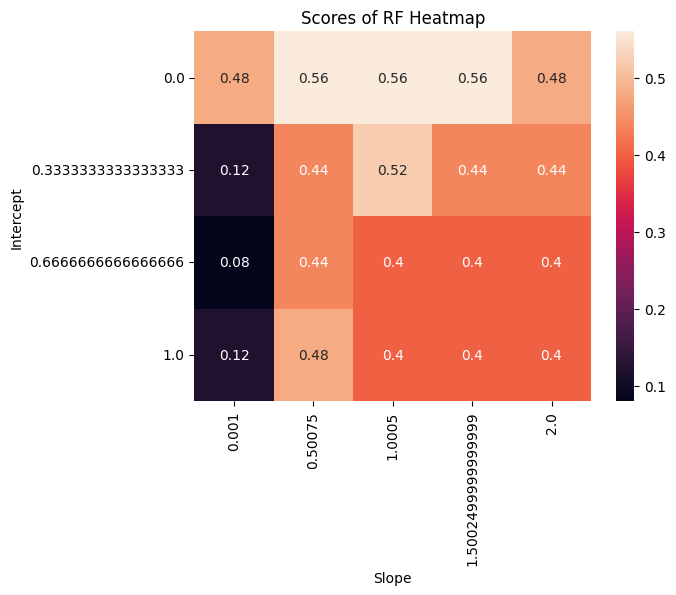

In [ ]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Run on GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Manipulations to original orbits
coords_tensor = torch.from_numpy(coords)

# Define the steps for each parameter
first_steps = np.linspace(0, 1, 4)
second_steps = np.linspace(0.001, 2, 5)

# Hyperparameters
bandwidth = 0.005
grid_size = 20
resolution = (grid_size, grid_size)
time_subd = torch.tensor([0.]).to(device)
m = torch.tensor(0.1).to(device)
time_subd = time_subd.to("cpu")
m = m.to("cpu")

# Initialize a matrix to store the results
results_matrix = np.zeros((len(first_steps), len(second_steps)))

for i, first in enumerate(first_steps):
    for j, second in enumerate(second_steps):
        # Initialize parameters with different versions
        init_param = torch.tensor([first, second], dtype=torch.float32).to(device)
        best_param = init_param.to("cpu")

        # Create diagram
        diag0_list, diag1_list = create_pd_collec(coords_tensor, best_param, time_subd, m)


        # Remove requires_grad from empty diagrams
        diag1_list[:] = [diag1.detach() if diag1.requires_grad else diag1 for diag1 in diag1_list]
        diag0_list[:] = [diag0.detach() if diag0.requires_grad else diag0 for diag0 in diag0_list]

        # Create PI's
        pi0_array = PersistenceImage(resolution=resolution, bandwidth=bandwidth).fit_transform(diag0_list)
        pi1_array = PersistenceImage(resolution=resolution, bandwidth=bandwidth).fit_transform(diag1_list)

        # Concatenate all the persistence diagram per orbit
        features = np.concatenate((pi0_array, pi1_array), 1)

        labels_to_int = {val: idx for idx, val in enumerate(np.unique(coords[:0]))}
        labels = coords[:, 0].astype(int)


        # Split the data into 90% training and 10% testing
        train_features, test_features, train_labels, test_labels = train_test_split(
            features, labels, test_size=0.1, random_state=42)

        # Instantiate model with 100 decision trees
        rf = RandomForestClassifier(n_estimators=100, random_state=42)

        # Train the model on training data
        rf.fit(train_features, train_labels)

        # Evaluate the model on the test data
        score = rf.score(test_features, test_labels)

        # Print the score and the init_param after each run
        print(f"Parameters: {init_param}, Score: {score}")

        # Store the score in the results matrix
        results_matrix[i, j] = score

# Visualize the results using a heatmap
sns.heatmap(results_matrix, annot=True, xticklabels=second_steps, yticklabels=first_steps)
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.title('Scores of RF Heatmap')
plt.show()

In [ ]:
results_matrix

array([[0.48, 0.48, 0.76, 0.8 , 0.8 ],
       [0.2 , 0.8 , 0.8 , 0.8 , 0.8 ],
       [0.36, 0.88, 0.84, 0.84, 0.84],
       [0.36, 0.88, 0.84, 0.84, 0.84]])

## Running the RF pipeline with one line (no cross validation)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Manipulations to original orbits
coords_tensor = torch.from_numpy(coords)

# Hyperparameters
bandwidth = 0.005
grid_size = 20
resolution = (grid_size, grid_size)


# Initialize parameters
init_param = torch.tensor([2., 1.0]).to(device)
time_subd = torch.tensor([0.]).to(device)
m = torch.tensor(0.1).to(device)

# Using the best parameters, create PD
best_param = init_param.to("cpu")
time_subd = time_subd.to("cpu")
m = m.to("cpu")

if best_param.requires_grad:
  best_param = best_param.detach()
diag0_list, diag1_list = create_pd_collec(coords_tensor, best_param, time_subd, m)

# Remove requires_grad from empty diagrams
diag1_list[:] = [diag1.detach() if diag1.requires_grad else diag1 for diag1 in diag1_list]
diag0_list[:] = [diag0.detach() if diag0.requires_grad else diag0 for diag0 in diag0_list]

# Create PI's
pi0_array = PersistenceImage(resolution=resolution, bandwidth=bandwidth).fit_transform(diag0_list)
pi1_array = PersistenceImage(resolution=resolution, bandwidth=bandwidth).fit_transform(diag1_list)

# Concatenate all the persistence diagram per orbit
features = np.concatenate((pi0_array, pi1_array), 1)

labels_to_int = {val: idx for idx, val in enumerate(np.unique(coords[:0]))}
labels = coords[:, 0].astype(int)


# Split the data into 90% training and 10% testing
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.1, random_state=42)

# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels)

# Evaluate the model on the test data
score = rf.score(test_features, test_labels)

print("Accuracy:", score)


Accuracy: 0.84


## Running the RF pipeline with one line WITH cross validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Initialize a KFold object
kf = StratifiedKFold(n_splits=10)

# Initialize a list to store scores
scores = []

# Manipulations to original orbits
coords_tensor = torch.from_numpy(coords)
pre_labels = coords[:, 0].reshape(-1, 1)
pre_features = coords[:, 1:]

# Hyperparameters
epochs = 5
decay_speed = 30
lr = 1
bandwidth = 0.005
grid_size = 20
resolution = (grid_size, grid_size)


# Run on GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


for train_index, test_index in kf.split(pre_features, pre_labels):
  # Get training and testing coordinates
  train_coords = np.concatenate((pre_labels[train_index], pre_features[train_index]), 1)
  test_coords = np.concatenate((pre_labels[test_index], pre_features[test_index]), 1)

  # Initialize parameters
  train_coords_tensor = torch.from_numpy(train_coords).to(device)
  init_param = torch.tensor([0., 1.0005]).to(device)
  # init_param.requires_grad = True
  time_subd = torch.tensor([0.]).to(device)
  m = torch.tensor(0.1).to(device)

  # # Perform the optimization process to obtain best parameters
  # best_param, best_loss = optim_gamma_param(train_coords_tensor, init_param, time_subd, \
  #                                           r_list, epochs=epochs, lr=lr, \
  #                                           decay_speed=decay_speed, m=m)

  # Using the best parameters, create PD
  best_param = init_param.to("cpu")
  time_subd = time_subd.to("cpu")
  m = m.to("cpu")

  if best_param.requires_grad:
    best_param = best_param.detach()
  diag0_list, diag1_list = create_pd_collec(coords_tensor, best_param, time_subd, m)

  # Remove requires_grad from empty diagrams
  diag1_list[:] = [diag1.detach() if diag1.requires_grad else diag1 for diag1 in diag1_list]
  diag0_list[:] = [diag0.detach() if diag0.requires_grad else diag0 for diag0 in diag0_list]

  # Create PI's
  pi0_array = PersistenceImage(resolution=resolution, bandwidth=bandwidth).fit_transform(diag0_list)
  pi1_array = PersistenceImage(resolution=resolution, bandwidth=bandwidth).fit_transform(diag1_list)

  # Concatenate all the persistence diagram per orbit
  features = np.concatenate((pi0_array, pi1_array), 1)

  labels_to_int = {val: idx for idx, val in enumerate(np.unique(coords[:0]))}
  labels = coords[:, 0].astype(int)

  # Split into test and train
  train_features, test_features = features[train_index], features[test_index]
  train_labels, test_labels = labels[train_index], labels[test_index]

  # Instantiate model with 100 decision trees
  rf = RandomForestClassifier(n_estimators = 100, random_state=42)

  # Train the model on training data
  rf.fit(train_features, train_labels)

  # Evaluate the model on the test data and append the score to scores list
  score = rf.score(test_features, test_labels)
  print(score)
  scores.append(score)

# Calculate the average accuracy and standard deviation
average_accuracy = np.mean(scores)
std_accuracy = np.std(scores)

# Print the average accuracy and standard deviation
print("Average Accuracy:", average_accuracy)
print("Standard Deviation:", std_accuracy)

cuda:0
0.32
0.52
0.68
0.48
0.28
0.6
0.52
0.48
0.4
0.44
Average Accuracy: 0.4720000000000001
Standard Deviation: 0.11426285485668561


## Running RF pipeline with one line with cross validation with extra checks

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from collections import Counter  # New import for counting labels
import numpy as np
import torch

# Initialize a KFold object
kf = StratifiedKFold(n_splits=10)

# Initialize a list to store scores
scores = []

# Manipulations to original orbits
coords_tensor = torch.from_numpy(coords)
pre_labels = coords[:, 0].reshape(-1, 1)
pre_features = coords[:, 1:]

# Hyperparameters
epochs = 5
decay_speed = 30
lr = 1
bandwidth = 0.005
grid_size = 20
resolution = (grid_size, grid_size)

# Run on GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize dictionaries to keep track of total occurrences and errors for each label
total_occurrences = Counter()
total_errors = Counter()

# Initialize list to store indices of incorrect labels for each fold
incorrect_indices_list = []

fold_num = 1  # New line: Initialize fold number for tracking
for train_index, test_index in kf.split(pre_features, pre_labels):
    print(f"Processing Fold {fold_num}...")  # New line for tracking folds

    # Get training and testing coordinates
    train_coords = np.concatenate((pre_labels[train_index], pre_features[train_index]), 1)
    test_coords = np.concatenate((pre_labels[test_index], pre_features[test_index]), 1)

    # Initialize parameters
    train_coords_tensor = torch.from_numpy(train_coords).to(device)
    init_param = torch.tensor([0., 1.0005]).to(device)
    time_subd = torch.tensor([0.]).to(device)
    m = torch.tensor(0.1).to(device)

    # Using the best parameters, create PD
    best_param = init_param.to("cpu")
    time_subd = time_subd.to("cpu")
    m = m.to("cpu")

    if best_param.requires_grad:
        best_param = best_param.detach()
    diag0_list, diag1_list = create_pd_collec(coords_tensor, best_param, time_subd, m)

    # Remove requires_grad from empty diagrams
    diag1_list[:] = [diag1.detach() if diag1.requires_grad else diag1 for diag1 in diag1_list]
    diag0_list[:] = [diag0.detach() if diag0.requires_grad else diag0 for diag0 in diag0_list]

    # Create PI's
    pi0_array = PersistenceImage(resolution=resolution, bandwidth=bandwidth).fit_transform(diag0_list)
    pi1_array = PersistenceImage(resolution=resolution, bandwidth=bandwidth).fit_transform(diag1_list)

    # Concatenate all the persistence diagram per orbit
    features = np.concatenate((pi0_array, pi1_array), 1)

    labels_to_int = {val: idx for idx, val in enumerate(np.unique(coords[:, 0]))}
    labels = np.array([labels_to_int[label] for label in coords[:, 0]])

    # Split into test and train
    train_features, test_features = features[train_index], features[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

    # New lines: Print label distribution for current fold
    print(f"Label distribution in training set: {Counter(train_labels)}")
    print(f"Label distribution in test set: {Counter(test_labels)}")

    # Instantiate model with 100 decision trees
    rf = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the model on training data
    rf.fit(train_features, train_labels)

    # Evaluate the model on the test data and append the score to scores list
    score = rf.score(test_features, test_labels)
    print(f"Score: {score}")  # Updated existing print statement
    scores.append(score)

    # New lines: Get predictions to analyze incorrect labels
    predictions = rf.predict(test_features)
    incorrect_indices = np.where(predictions != test_labels)[0]
    if len(incorrect_indices) > 0:
        print("Incorrectly classified labels:")
        for idx in incorrect_indices:
            print(f"True Label: {test_labels[idx]}, Predicted: {predictions[idx]}")

    # Update total occurrences and errors
    total_occurrences.update(test_labels)
    incorrect_labels = test_labels[incorrect_indices]
    total_errors.update(incorrect_labels)

    # Save the indices of incorrect labels for this fold
    incorrect_indices_list.append(test_index[incorrect_indices])

    fold_num += 1  # New line: Increment the fold number

# Calculate the average accuracy and standard deviation
average_accuracy = np.mean(scores)
std_accuracy = np.std(scores)

# Print the average accuracy and standard deviation
print("Average Accuracy:", average_accuracy)
print("Standard Deviation:", std_accuracy)

# Calculate the failure rate for each label
failure_rate = {}
for label, total in total_occurrences.items():
    failure_rate[label] = (total_errors[label] / total) * 100 if label in total_errors else 0

# Sort labels by failure rate
sorted_failure_rate = {k: v for k, v in sorted(failure_rate.items(), key=lambda item: item[1], reverse=True)}

# Print the sorted failure rates
print("Failure rate by label:")
for label, rate in sorted_failure_rate.items():
    print(f"Label {label}: {rate:.2f}% of the time it is wrong")


cuda:0
Processing Fold 1...


KeyboardInterrupt: ignored

In [ ]:
incorrect_indices_list

[array([  0,   1,   2,   3,  53, 100, 101, 102, 103, 150, 152, 153, 200,
        201, 202, 203]),
 array([  8,  55,  56,  57,  59, 105, 106, 107, 108, 109, 155, 156, 158,
        207]),
 array([ 12,  14,  62, 110, 111, 113, 114, 160, 161, 162, 163, 210, 211,
        212, 213, 214]),
 array([ 15,  17,  18,  67, 115, 116, 117, 166, 167, 168, 169, 215, 217,
        218, 219]),
 array([ 20,  21,  73,  74, 120, 121, 123, 124, 170, 173, 220, 222, 223,
        224]),
 array([ 26,  27,  29,  75,  76,  79, 126, 127, 129, 175, 177, 226, 227,
        229]),
 array([ 30,  31,  32,  33,  80,  81,  82,  84, 130, 131, 132, 133, 182,
        183, 184, 230, 231, 232, 233, 234]),
 array([ 35,  37,  38,  85,  88, 135, 136, 137, 138, 139, 186, 188, 189,
        235, 236, 237, 238, 239]),
 array([ 41,  90,  91,  93,  94, 140, 141, 143, 144, 190, 192, 193, 194,
        240, 241, 243]),
 array([ 47,  97,  98,  99, 145, 146, 147, 149, 196, 197, 198, 199, 245,
        246, 248, 249])]

tensor(2.)


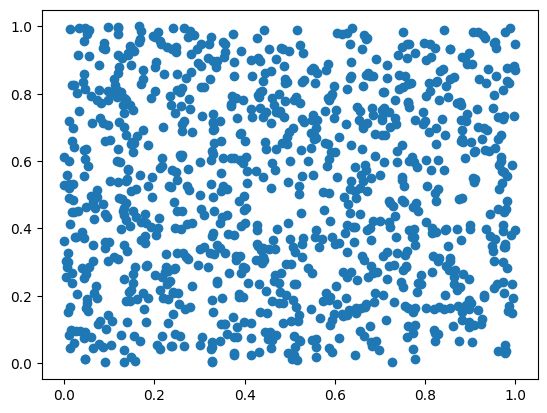

1000


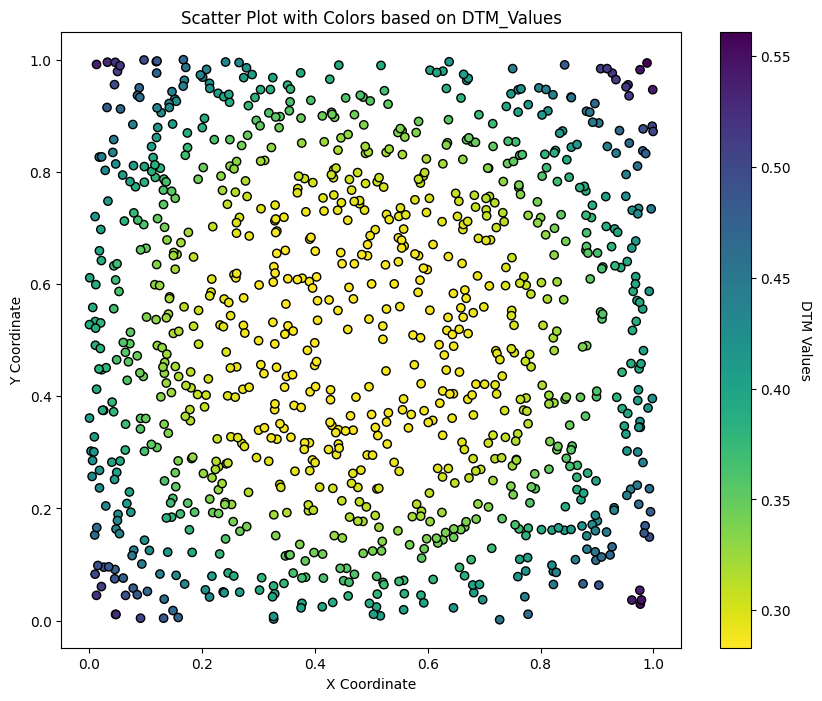

In [ ]:


coords_tensor = torch.from_numpy(coords)
coord = coords_tensor[100]
x = coord[1 : data_total_amount+1]
y = coord[data_total_amount + 1: ]
pts = torch.stack((x, y), dim=-1)
label = coord[0]
print(label)
plt.scatter(pts[:, 0], pts[:, 1])
plt.show()


m = 0.5
DTM_Values = DTM(pts, pts, m)
print(len(DTM_Values))

# Create the scatter plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(pts[:, 0], pts[:, 1], c=DTM_Values, cmap='viridis_r', edgecolors='k')

# Add a colorbar to show the mapping from DTM_Values to colors
cbar = plt.colorbar(sc)
cbar.set_label('DTM Values', rotation=270, labelpad=15)

# Add axis labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot with Colors based on DTM_Values')

# Show the plot
plt.show()

What is the persistence diagram of this like for different `m` valus and different lines? Let us compare!



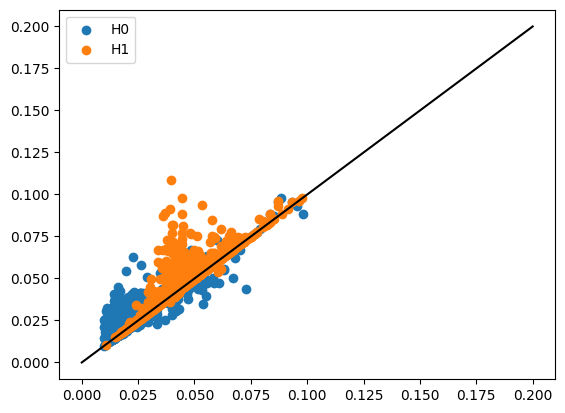

hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit0
hit1
hit1
hit1
hit1
hit1
hit1
hit1
hit1


In [ ]:
parameters = torch.tensor([0.1, 1.5, 3.5])
time_subd = torch.tensor([0., 2.])
diag0, diag1 = gamma_pd(parameters, time_subd, pts, m=0.1, dimension_max=2)
plt.scatter(diag0[:, 0], diag0[:, 1], label="H0")
plt.scatter(diag1[:, 0], diag1[:, 1], label="H1")
plt.plot(np.linspace(0, 0.2), np.linspace(0, 0.2), c='k')
plt.legend()
plt.show()

for x,y in diag0:
  if x > y:
    print("hit0")

for x,y in diag1:
  if x > y:
    print("hit1")

## DTM Distribution

tensor(0.3762)
tensor(0.6840)


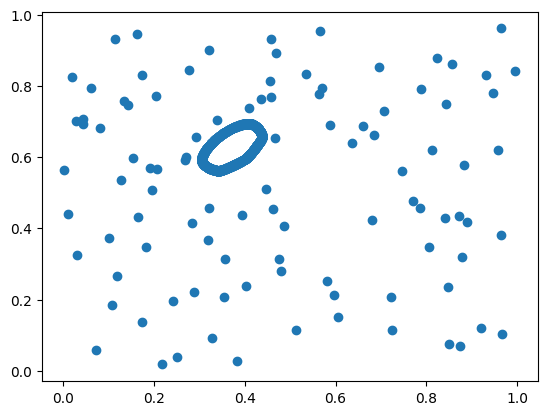

In [ ]:
x = coord[1 : data_total_amount+1]
y = coord[data_total_amount + 1: ]
pts = torch.stack((x, y), dim=-1)
label = coord[0]



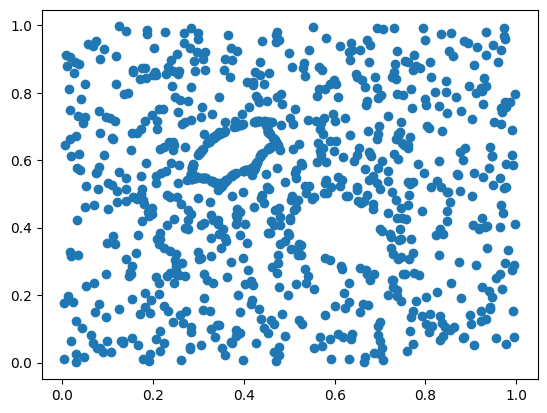

In [ ]:
# Functions needed for creation of dataset
def fx(x, y, r):
  return (x + r * y * (1 - y)) % 1

def fy(x, y, r):
  return (y + r * x * (1 - x)) % 1

# Random starting points
xlist = [0.35562]
ylist = [0.6840]
r=4.3

for i in range(999):
  # Creation of new datapoint
  xn = fx(xlist[i], ylist[i], r)
  yn = fy(xn, ylist[i], r)

  # Keeping track of data\
  xlist.append(xn)
  ylist.append(yn)

# A collection of all x and y coordinates
xlist = np.stack(xlist).T
ylist = np.stack(ylist).T

plt.scatter(xlist, ylist)
plt.show()

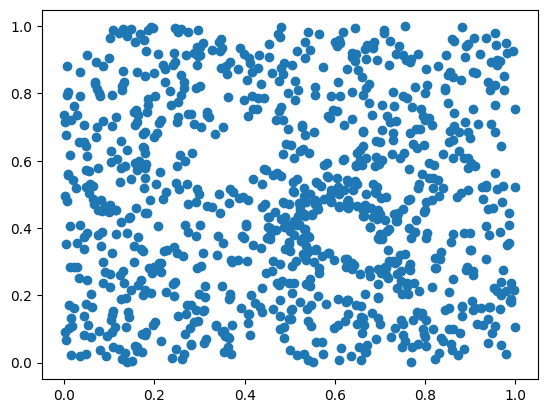

In [ ]:
coords_tensor = torch.from_numpy(coords)
coord = coords_tensor[203]
kiki=950
x = coord[1 : kiki+1]
y = coord[kiki + 1: ]
pts = torch.stack((x, y), dim=-1)

plt.scatter(pts[:, 0], pts[:, 1])
plt.show()

In [ ]:
m = 0.1

max_list = []
label_list = []
coords_tensor = torch.from_numpy(coords)

for coord in coords_tensor:
  # Extract x and y coordinates and combine into point set
  x = coord[1 : data_total_amount+1]
  y = coord[data_total_amount + 1: ]
  pts = torch.stack((x, y), dim=-1)
  label = coord[0]

  DTM_Values = DTM(pts, pts, m)

  max_dtm = max(DTM_Values)

  max_list.append(max_dtm)
  label_list.append(label)

In [ ]:
sorted_max_list = sorted(max_list, reverse=True)
print(sorted_max_list[-1])

tensor(0.0118)


In [ ]:
index = max_list.index(sorted_max_list[1])
print(index)

218


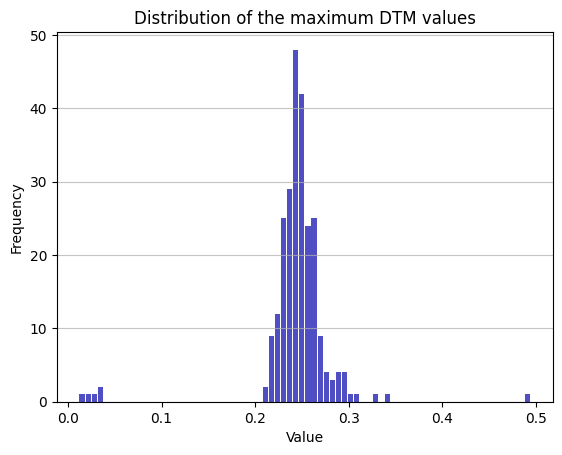

In [ ]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=max_list, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of the maximum DTM values')
plt.show()

tensor(4.)
tensor(0.9789)
tensor(0.0916)


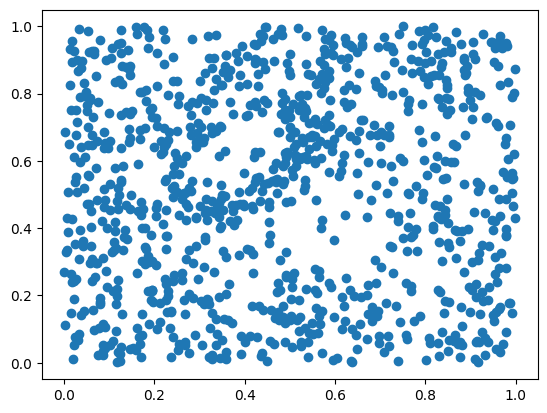

In [ ]:
coords_tensor = torch.from_numpy(coords)
coord = coords_tensor[218]

x = coord[1 : data_total_amount+1]
y = coord[data_total_amount + 1: ]
pts = torch.stack((x, y), dim=-1)

print(coord[0])
print(coord[1])
print(coord[data_total_amount + 1])
plt.scatter(pts[:, 0], pts[:, 1])
plt.show()

## Rest

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Initialize a KFold object
kf = StratifiedKFold(n_splits=10)

# Initialize a list to store scores
scores = []

# Manipulations to original orbits
coords_tensor = torch.from_numpy(coords)
pre_labels = coords[:, 0].reshape(-1, 1)
pre_features = coords[:, 1:]

# Hyperparameters
epochs = 5
decay_speed = 30
lr = 1
bandwidth = 0.005
grid_size = 20
resolution = (grid_size, grid_size)


# Run on GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


for train_index, test_index in kf.split(pre_features, pre_labels):

  # Get training and testing coordinates
  train_coords = np.concatenate((pre_labels[train_index], pre_features[train_index]), 1)
  test_coords = np.concatenate((pre_labels[test_index], pre_features[test_index]), 1)

  # Initialize parameters
  train_coords_tensor = torch.from_numpy(train_coords).to(device)
  init_param = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1]).to(device)
  time_subd = torch.tensor([0, 0.1, 0.2, 0.3]).to(device)
  m = torch.tensor(0.1).to(device)

  # # Perform the optimization process to obtain best parameters
  # best_param, best_loss = optim_gamma_param(train_coords_tensor, init_param, time_subd, \
  #                                           r_list, epochs=epochs, lr=lr, \
  #                                           decay_speed=decay_speed, m=m)

  # Using the best parameters, create PD
  best_param = init_param.to("cpu")
  time_subd = time_subd.to("cpu")
  m = m.to("cpu")

  if best_param.requires_grad:
    best_param = best_param.detach()
  diag0_list, diag1_list = create_pd_collec(coords_tensor, best_param, time_subd, m)

  # Remove requires_grad from empty diagrams
  diag1_list[:] = [diag1.detach() if diag1.requires_grad else diag1 for diag1 in diag1_list]
  diag0_list[:] = [diag0.detach() if diag0.requires_grad else diag0 for diag0 in diag0_list]

  # Create PI's
  pi0_array = PersistenceImage(resolution=resolution, bandwidth=bandwidth).fit_transform(diag0_list)
  pi1_array = PersistenceImage(resolution=resolution, bandwidth=bandwidth).fit_transform(diag1_list)

  # Concatenate all the persistence diagram per orbit
  features = np.concatenate((pi0_array, pi1_array), 1)

  labels_to_int = {val: idx for idx, val in enumerate(np.unique(coords[:0]))}
  labels = coords[:, 0].astype(int)

  # Split into test and train
  train_features, test_features = features[train_index], features[test_index]
  train_labels, test_labels = labels[train_index], labels[test_index]

  # Instantiate model with k neighbors
  knn = KNeighborsClassifier(n_neighbors=3)

  # Normalize data
  scaler = StandardScaler()
  train_features = scaler.fit_transform(train_features)
  test_features = scaler.transform(test_features)

  # Train the model on training data
  knn.fit(train_features, train_labels)

  # Evaluate the model on the test data and append the score to scores list
  scores.append(knn.score(test_features, test_labels))

# Calculate the average accuracy and standard deviation
average_accuracy = np.mean(scores)
std_accuracy = np.std(scores)

# Print the average accuracy and standard deviation
print("Average Accuracy:", average_accuracy)
print("Standard Deviation:", std_accuracy)

cpu
Average Accuracy: 0.46799999999999997
Standard Deviation: 0.10740577265678042


In [ ]:
# Run on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


parameters = torch.tensor([0.001, 0.001, 0.1, 0.1, 0.1]).to(device)
time_subd = torch.tensor([0., 0.2, 0.4, 0.6]).to(device)
m = torch.tensor(0.1).to(device)

# Create label_indices
# get unique labels
unique_labels = torch.unique(coords_tensor[:, 0])

# create lookup table
label_indices = {}

# loop over each unique label
for i, unique_label in enumerate(unique_labels):
    indices = (coords_tensor[:, 0] == unique_label).nonzero(as_tuple=True)[0]
    label_indices[int(i)] = indices


import timeit

start_time = timeit.default_timer()
diag0_list, diag1_list = create_pd_collec(coords_tensor, parameters, time_subd, m)
print(f"Time to create diagrams: {timeit.default_timer() - start_time}")
start_time = timeit.default_timer()
loss = loss_class(diag0_list, diag1_list, parameters, time_subd, label_indices, r_list, m)
print(f"Class time: {timeit.default_timer() - start_time}")

cpu
Time to create diagrams: 1.0257181000006312
Class time: 4.076312782999594


In [ ]:
print(loss)

tensor(0.8915)


In [ ]:
label_indices

{2.5: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 3.5: tensor([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 4.0: tensor([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 4.099999904632568: tensor([30, 31, 32, 33, 34, 35, 36, 37, 38, 39]),
 4.300000190734863: tensor([40, 41, 42, 43, 44, 45, 46, 47, 48, 49])}

In [ ]:
import torch
x = torch.tensor([[2,3],[5,6],[7,8]])
y = torch.tensor([[0,0,1,2,3,5]])

In [ ]:
z = torch.tensor([0, 2])

diag_list =
x[z]

tensor([2, 5])

In [ ]:

coords_tensor = torch.from_numpy(coords).to(device)
unique_labels = torch.unique(coords_tensor[:, 0])

# create lookup table
label_indices = {}

# loop over each unique label
for i, unique_label in enumerate(unique_labels):
    indices = (coords_tensor[:, 0] == unique_label).nonzero(as_tuple=True)[0]
    label_indices[unique_label.item()] = indices


cpu


In [ ]:
# get diagrams for label 0
indices = label_indices[r_list[0]].tolist()
diagrams = [diag0_list[i] for i in indices]

In [ ]:
indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
diag0_list[:10] == diagrams

True

In [ ]:
torch.tensor([2.4], requires_grad=True)

True

In [ ]:
x = np.array([[2.,3.], [3.,4.]])
y = np.array([[9.], [8.]])

np.concatenate((y,x), 1)

array([[9., 2., 3.],
       [8., 3., 4.]])

In [ ]:
# A single diagram with 4 points
D1 = torch.tensor([[0.,4.],[1.,2.],[3.,8.],[6.,8.]])
D2 = torch.tensor([[0.,5.],[1.,3.],[3.,6.],[6.,7.]])
D3 = torch.tensor([[0.,5.],[1.,3.],[3.,6.],[6.,7.]])
diags = [D1, D2, D3]

pi = PersistenceImage(resolution=[20,20]).fit_transform(diags)

# A single diagram with 4 points
D1 = torch.tensor([[0.,4.],[1.,2.],[3.,8.],[6.,8.]])
D2 = torch.tensor([[0.,5.],[1.,3.],[3.,6.],[6.,7.]])
D3 = torch.tensor([[0.,5.],[1.,3.],[3.,6.],[6.,7.]])
diags = [D1, D2, D3]

pi2 = PersistenceImage(resolution=[20,20]).fit_transform(diags)

In [ ]:
np.concatenate((pi, pi2), 1).shape

(3, 800)

In [ ]:
# Assuming you have a tensor with requires_grad=True
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

# Detach the tensor from the computation graph and set requires_grad to False
x = x.detach()

In [ ]:
x.requires_grad

False

In [ ]:
diag1_list

[tensor([[0.1743, 0.1792],
         [0.1845, 0.2022],
         [0.1917, 0.2080]]),
 tensor([[0.1645, 0.2121],
         [0.2181, 0.2310],
         [0.2022, 0.2353]]),
 tensor([[0.1323, 0.1527]]),
 tensor([[0.1298, 0.1397],
         [0.1490, 0.1667]]),
 tensor([[0., 0.]], requires_grad=True),
 tensor([[0., 0.]], requires_grad=True),
 tensor([[0.1782, 0.1908]]),
 tensor([[0.1130, 0.1137]]),
 tensor([[0.0934, 0.0963]]),
 tensor([[0.1145, 0.1160],
         [0.1757, 0.1760]]),
 tensor([[0.1529, 0.1563],
         [0.1515, 0.1564],
         [0.1654, 0.1676],
         [0.1482, 0.1728]]),
 tensor([[0.1137, 0.1149]]),
 tensor([[0.1513, 0.1533],
         [0.1512, 0.1565]]),
 tensor([[0.1687, 0.1766]]),
 tensor([[0.1634, 0.1700]]),
 tensor([[0.1244, 0.1275],
         [0.1672, 0.1701]]),
 tensor([[0.1488, 0.1579],
         [0.1652, 0.1850]]),
 tensor([[0.1363, 0.1385]]),
 tensor([[0., 0.]], requires_grad=True),
 tensor([[0.1323, 0.1407],
         [0.1345, 0.1410]]),
 tensor([[0.1425, 0.1467],
      

In [ ]:
a = [1, 3, 5]
b = a.copy()
a[:] = [x + 2 for x in a]
print(a)
print(b)

[3, 5, 7]
[1, 3, 5]
